In [4]:
import numpy as np
import pandas as pd
import os

In [5]:
import librosa
import numpy as np
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix
import os
import numpy as np
import joblib

In [6]:
# directories for screaming and non screaming audio for both inside and outside
in_scream_dir = "C:\\Users\\acer\\OneDrive\\Desktop\\HSD\\dataSet_inside\\Converted_Separately\\scream"
in_non_scream_dir = "C:\\Users\\acer\\OneDrive\\Desktop\\HSD\\dataSet_inside\\Converted_Separately\\non_scream"
out_scream_dir = "C:\\Users\\acer\\OneDrive\\Desktop\\HSD\\dataSet-outside\\Screaming"
out_non_scream_dir = "C:\\Users\\acer\\OneDrive\\Desktop\\HSD\\dataSet-outside\\NotScreaming"

RATE = 44100  # Sample rate

In [10]:
def individual_audio_features(y):
    mfccs = librosa.feature.mfcc(y=y, sr=RATE, n_mfcc=13) # mfcc -> mel-frequency cepstrum coeff.
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=RATE) # spectral contrast
    chroma = librosa.feature.chroma_stft(y=y, sr=RATE) # chroma features
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y) # 0 corssing rate
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=RATE) # spectral centroid
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=RATE) # spectral bandwidth
    rmse = librosa.feature.rms(y=y) # root mean sq energy
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=RATE) # spectral roll off
    # beats per minute
    onset_env = librosa.onset.onset_strength(y=y, sr=RATE)
    tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=RATE)
    
    feature_vector = np.hstack([
        np.mean(mfccs, axis=1),             
        np.mean(spectral_contrast, axis=1), 
        np.mean(chroma, axis=1),         
        np.mean(zero_crossing_rate),     
        np.mean(spectral_centroid),      
        np.mean(spectral_bandwidth),    
        np.mean(rmse),                  
        np.mean(spectral_rolloff),      
        tempo                          
    ])    
    return feature_vector

In [11]:
def load_audio_file(directory):
    audio_features = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            y, _ = librosa.load(file_path, sr=RATE)
            features = individual_audio_features(y)
            audio_features.append(features)
    
    return np.array(audio_features)

In [12]:
X_scream_1 = load_audio_file(in_scream_dir)
print("1st dir completed")
X_scream_2 = load_audio_file(out_scream_dir)
print("2nd dir completed")
X_scream = np.vstack([X_scream_1, X_scream_2])

X_non_scream_1 = load_audio_file(in_non_scream_dir)
print("3rd dir completed")
X_non_scream_2 = load_audio_file(out_non_scream_dir)
print("4th dir completed")
X_non_scream = np.vstack([X_non_scream_1, X_non_scream_2])
  
print(f"Scream features shape: {X_scream.shape}")
print(f"Non-scream features shape: {X_non_scream.shape}")


C:\Users\acer\AppData\Local\Temp\ipykernel_18940\2845026965.py:12: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=RATE)
C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


1st dir completed
2nd dir completed
3rd dir completed
4th dir completed
Scream features shape: (2445, 38)
Non-scream features shape: (4176, 38)


In [13]:
X = np.vstack([X_scream, X_non_scream])
y_screams = np.ones(len(X_scream))
y_non_screams = np.zeros(len(X_non_scream))
y = np.hstack([y_screams, y_non_screams])

In [14]:
print(X.shape)
print(y.shape)

(6621, 38)
(6621,)


In [32]:
std = StandardScaler()
X = std.fit_transform(X)

In [33]:
data = pd.DataFrame(X)
data

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,-0.482530,-1.438952,-1.101677,-0.113792,1.058561,0.488922,1.720744,-0.467755,-0.628656,0.970018,...,-1.403307,-1.618946,-1.446762,-1.170324,0.542139,0.656914,-0.437587,-0.455822,0.402907,0.558095
1,-1.086956,-1.204024,0.887710,0.020991,0.799679,0.602464,0.817815,0.175531,0.007295,0.104246,...,-0.723509,0.279771,1.572962,-0.010966,-0.486261,-0.472462,-0.643264,-0.903726,-0.496325,0.350468
2,-0.350064,-1.192304,-1.923286,-1.538495,0.067829,0.607211,2.869157,0.189706,-1.308540,1.236362,...,-0.792088,0.497840,-1.455801,-2.020585,0.317506,0.056640,-0.801688,0.251750,-0.308184,0.558095
3,-0.094865,0.395920,0.353865,-0.495084,0.437733,-0.351223,0.606724,0.711256,0.458434,0.357824,...,0.715514,0.394195,0.212352,0.185817,-0.611721,-0.802469,-0.767140,-0.224655,-0.699563,0.350468
4,-0.274082,0.612170,0.918420,-1.149466,0.084080,0.084517,-0.026533,0.265013,0.568041,-0.760342,...,0.074856,-0.053546,0.163256,1.087381,-0.529416,-1.009172,-1.034637,0.166342,-1.007576,0.153222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6616,-1.463541,-0.448600,1.276753,0.280674,-0.845566,0.083171,0.705812,-0.898012,-0.043343,-0.389673,...,0.108954,0.198638,0.230507,0.595164,0.127410,0.207659,0.816291,-1.093789,0.524319,0.153222
6617,1.094023,0.812874,0.508656,1.298854,-0.523503,0.981289,-0.310690,0.134591,0.890048,-0.518258,...,-0.022397,-0.013638,0.165482,0.076858,-0.838675,-0.632857,0.065829,0.810161,-0.482345,-0.850160
6618,-0.364640,-0.936267,0.478862,0.773056,1.198929,0.510726,0.193021,0.200042,0.625738,0.516748,...,-0.270995,0.041645,-0.218534,-0.160558,0.861947,0.960319,1.016023,-0.512986,0.727227,-0.034403
6619,1.070081,0.812210,-1.054415,2.603901,-1.103017,-0.990794,1.621444,-2.528767,2.473780,1.012429,...,1.368867,0.048809,0.420221,1.206387,1.911999,1.070738,0.517700,0.029711,1.068407,-2.044662


<Axes: >

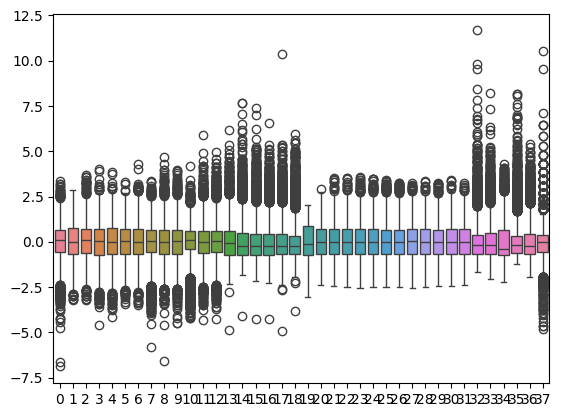

In [ ]:
import seaborn as sns
sns.boxplot(X)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(5296, 38) (1325, 38) (5296,) (1325,)


In [35]:
random_forest_model = RandomForestClassifier(random_state=42)
random_forest_model.fit(X_train, y_train)

y_pred = random_forest_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")


Accuracy: 0.88
Confusion Matrix:
[[779  49]
 [110 387]]


In [36]:
svm_model = SVC(C=7.296763473483312, kernel='rbf', gamma='auto', random_state=42)
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_conf_matrix = confusion_matrix(y_test, y_pred_svm)

print(f"Accuracy: {svm_accuracy}")
print(f"Confusion Matrix:\n{svm_conf_matrix}")


Accuracy: 0.9033962264150943
Confusion Matrix:
[[770  58]
 [ 70 427]]


In [37]:
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, y_train)

y_pred_logistic = logistic_model.predict(X_test)
logistic_accuracy = accuracy_score(y_test, y_pred_logistic)
logistic_conf_matrix = confusion_matrix(y_test, y_pred_logistic)

print(f" Accuracy: {logistic_accuracy}")
print(f" Confusion Matrix:\n{logistic_conf_matrix}")


 Accuracy: 0.8649056603773585
 Confusion Matrix:
[[767  61]
 [118 379]]


In [38]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train,y_train)

y_pred_xgb = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test,y_pred)
xgb_conf_matrix = confusion_matrix(y_test, y_pred_xgb)

print(f"Accuracy: {xgb_accuracy}")
print(f"Confusion Matrix:\n{xgb_conf_matrix}")

Accuracy: 0.88
Confusion Matrix:
[[767  61]
 [ 82 415]]


In [39]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train,y_train)

y_pred_knn = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_pred,y_test)
knn_conf_matrix = confusion_matrix(y_test,y_pred_knn)

print(f"Accuracy: {knn_accuracy}")
print(f"Confusion Matrix:\n{knn_conf_matrix}")

Accuracy: 0.88
Confusion Matrix:
[[735  93]
 [ 85 412]]


In [40]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train,y_train)

y_pred_dt = dt_model.predict(X_test)
dt_accuracy = accuracy_score(y_pred,y_test)
dt_conf_matrix = confusion_matrix(y_test,y_pred_dt)

print(f"Accuracy: {dt_accuracy}")
print(f"Confusion Matrix:\n{dt_conf_matrix}")

Accuracy: 0.88
Confusion Matrix:
[[692 136]
 [129 368]]


In [41]:
joblib.dump(random_forest_model,"random_forest_classifier.pkl")
joblib.dump(svm_model,"svm_classifier.pkl")
joblib.dump(logistic_model,"logistic_reg_classifier.pkl")
joblib.dump(xgb_model,"xgb_classifier.pkl")
joblib.dump(knn_model,"knn_classifier.pkl")
joblib.dump(dt_model,"decision_tree_classifier.pkl")

['decision_tree_classifier.pkl']